Import necessary libraries

note: 注意numpy的第0维指的是一行的维度数，第1维是一列的维度数
图像的尺寸height * width, 其中height是第1维，width是第0维

**注意：在numpy中，读取数组尽量先行后列，因为计算机是按照行的顺序来存的**

可以用min函数来防止数组越界

bicubic可以用一个核函数来实现，效率更高

np.clip()可以将输出限制在一个范围之内

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import math
from scipy.interpolate import interp2d
import time

In [2]:
def bilinear_original(input_file, dim):
    if not os.path.exists(input_file):
        print("The file does not exist.")
        return
    img = plt.imread(input_file)    # this is already a numpy ndarray
    out_img = np.zeros(dim, dtype=img.dtype)
    # default is uint8, when substracting, it may encouter overflow
    img = img.astype(int)
    tmp = np.zeros((img.shape[0],dim[1]), dtype=img.dtype)
    # first interpolate along the y-axis
    for i in range(img.shape[0]):
        for j in range(dim[1]):
            y = j*(img.shape[1]-1)/(dim[1]-1)
            y1 = math.floor(y)
            if y1 == img.shape[1]-1:    # if y is exactly the last index
                y1 -= 1
            tmp[i,j] = img[i,y1] + (y-y1)*(img[i,y1+1]-img[i,y1])
    
    # then interpolate along the x-axis
    for i in range(dim[0]):
        for j in range(dim[1]):
            x = i*(img.shape[0]-1)/(dim[0]-1)
            x1 = math.floor(x)
            if x1 == img.shape[0]-1:
                x1 -= 1
            out_img[i,j] = tmp[x1,j] + (x-x1)*(tmp[x1+1,j]-tmp[x1,j])
    return out_img

In [3]:
def bilinear_huangtingjun(input_file, dim):
    if not os.path.exists(input_file):
        print("The file does not exist.")
        return
    img = plt.imread(input_file)    # this is already a numpy ndarray
    out_img = np.zeros(dim, dtype=img.dtype)

    for x in range(dim[0]):
        x1 = x * (img.shape[0]-1) / (dim[0] - 1)
        x2 = math.floor(x1)
        m = x1 - x2
        if x2 == img.shape[0]-1:
            x2 -= 1
        for y in range(dim[1]):
            # find corresponding pixels in img
            y1 = y * (img.shape[1]-1) / (dim[1] - 1)
            y2 = math.floor(y1)
            n = y1 - y2
            if y2 == img.shape[1]-1:
                y2 -= 1
            # out_img[x, y] = (1-n) * (m * img[x2+1,y2] + (1-m) * img[x2,y2])+ n * (m * img[x2+1,y2+1] + (1-m)*img[x2,y2+1])
            out_img[x, y] = (1-n)*(1-m)*img[x2,y2] + n*(1-m)*img[x2,y2+1]+(1-n)*m*img[x2+1,y2] + n*m*img[x2+1,y2+1]
    return out_img

In [4]:
def nearest_huangtingjun(input_file, dim):
    if not os.path.exists(input_file):
        print("The file does not exist.")
        return
    img = plt.imread(input_file)    # this is already a numpy ndarray
    out_img = np.zeros(dim, dtype=img.dtype)

    for x in range(dim[0]):
        for y in range(dim[1]):
            # find corresponding pixels in img
            x1 = x * (img.shape[0]-1) / (dim[0] - 1)
            y1 = y * (img.shape[1]-1) / (dim[1] - 1)
            # find the nearest orginial pixel index
            x2 = round(x1)
            y2 = round(y1)
            
            out_img[x, y] = img[x2, y2]
    return out_img

In [5]:
def bicubic_huangtingjun(input_file, dim):
    if not os.path.exists(input_file):
        print("The file does not exist.")
        return
    img = plt.imread(input_file)    # this is already a numpy ndarray
    out_img = np.zeros(dim, dtype=img.dtype)
    # calculate the crossing points
    tmp = np.zeros((dim[0], img.shape[1]), dtype=img.dtype)
    for y in range(img.shape[1]):
        for x in range(dim[0]):
            # find corresponding pixels in img
            x1 = x * (img.shape[0]-1) / (dim[0] - 1)
            # find the nearest orginial pixel index
            m = np.array([np.floor(x1)-1, np.floor(x1), np.floor(x1)+1, np.floor(x1)+2])
            m_tmp = m.copy()
            m_tmp[m_tmp < 0] = np.abs(m_tmp[m_tmp < 0])
            m_tmp[m_tmp >= img.shape[0]] = 2*img.shape[0] - m_tmp[m_tmp >= img.shape[0]] - 1
            m_tmp = m_tmp.astype(int)
            n = np.array([img[m_tmp[0], y], img[m_tmp[1], y], img[m_tmp[2], y], img[m_tmp[3], y]])

            coefficients = np.polyfit(m, n, 3)
            poly = np.poly1d(coefficients)
            tmp[x, y] = poly(x1)
    
    for x in range(dim[0]):
        for y in range(dim[1]):
            # find corresponding pixels in img
            y1 = y * (img.shape[1]-1) / (dim[1] - 1)
            # find the nearest orginial pixel index
            m = np.array([np.floor(y1)-1, np.floor(y1), np.floor(y1)+1, np.floor(y1)+2])
            m_tmp = m.copy()
            m_tmp[m_tmp < 0] = np.abs(m_tmp[m_tmp < 0])
            m_tmp[m_tmp >= img.shape[1]] = 2*img.shape[1] - m_tmp[m_tmp >= img.shape[1]] - 1
            m_tmp = m_tmp.astype(int)
            n = np.array([tmp[x, m_tmp[0]], tmp[x, m_tmp[1]], tmp[x, m_tmp[2]], tmp[x, m_tmp[3]]])

            coefficients = np.polyfit(m, n, 3)
            poly = np.poly1d(coefficients)
            out_img[x, y] = poly(y1)
    return out_img

In [6]:
def bicubic_scipy(input_file, dim):
    if not os.path.exists(input_file):
        print("The file does not exist.")
        return
    img = plt.imread(input_file)    # this is already a numpy ndarray

    # create a function to interpolate
    f = interp2d(np.arange(img.shape[1]), np.arange(img.shape[0]), img, kind='cubic')

    # create a new image
    out_img = f(np.linspace(0, img.shape[1]-1, dim[1]), np.linspace(0, img.shape[0]-1, dim[0]))
    out_img = np.clip(out_img, 0, 255).astype(np.uint8)
    return out_img

Testing

This is a module for image interpolation.
The new dimension is 230*230.
Nearest: 0.035071372985839844 seconds.
Bilinear type1: 0.20204639434814453 seconds.
Bilinear type2: 0.2546045780181885 seconds.
Bicubic: 4.596865177154541 seconds.
Bicubic Scipy: 0.006014823913574219 seconds.


C:\Users\Tangent\AppData\Local\Temp\ipykernel_29104\1192072600.py:8: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(np.arange(img.shape[1]), np.arange(img.shape[0]), img, kind='cubic')
C:\Users\Tangent\AppData\Local\Temp\ipykernel_29104\1192072600.py:11: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, a

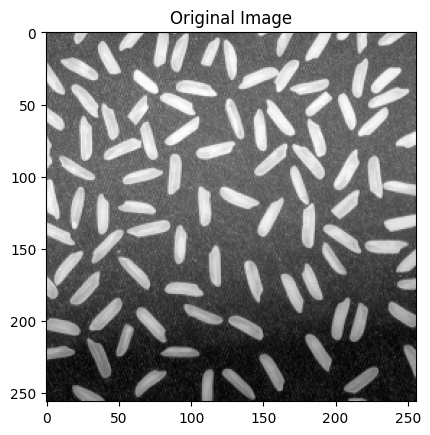

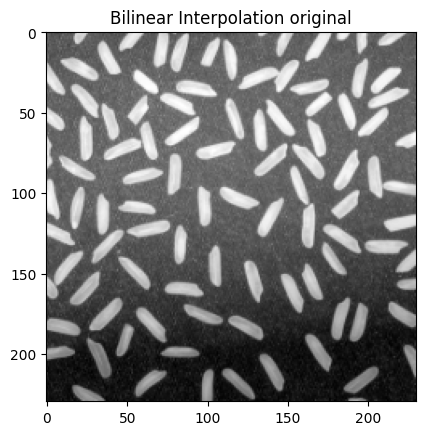

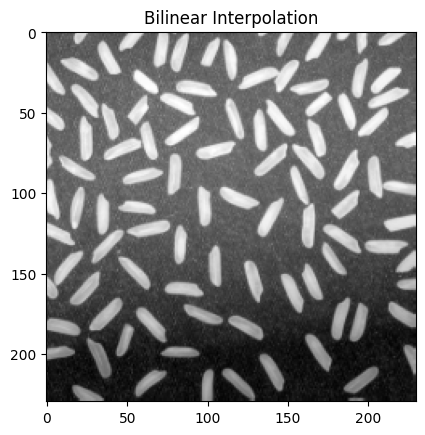

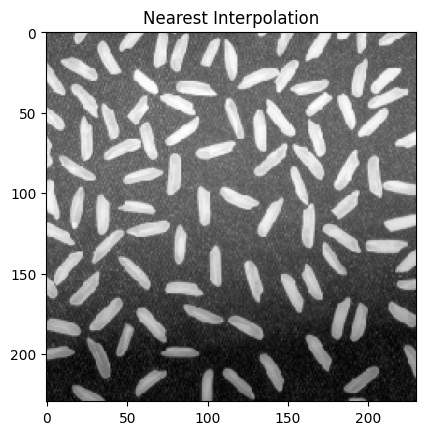

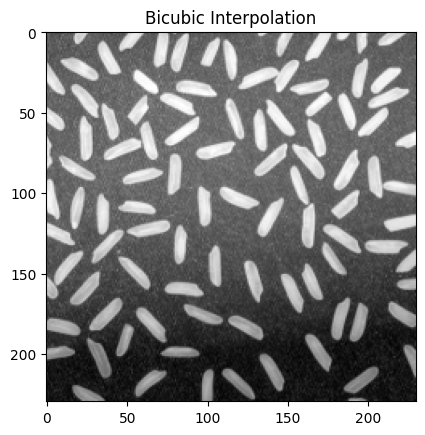

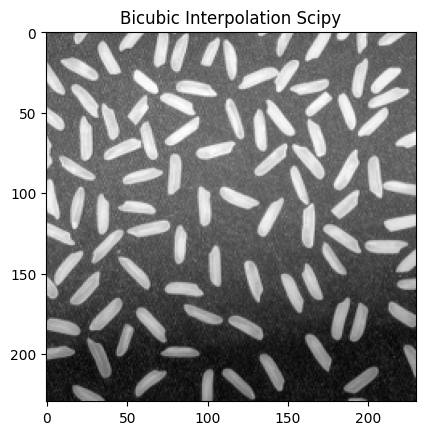

In [7]:
if __name__ == "__main__":
    print("This is a module for image interpolation.")
    dim = round(256*0.9)
    print(f"The new dimension is {dim}*{dim}.")
    image = plt.imread("rice.tif")
    # timing
    start = time.time()
    img_nearest = nearest_huangtingjun("rice.tif", (dim,dim))
    end = time.time()
    print(f"Nearest: {end-start} seconds.")

    start = time.time()
    img_bilinear_original = bilinear_original("rice.tif", (dim,dim))
    end = time.time()
    print(f"Bilinear type1: {end-start} seconds.")

    start = time.time()
    img_bilinear = bilinear_huangtingjun("rice.tif", (dim,dim))
    end = time.time()
    print(f"Bilinear type2: {end-start} seconds.")

    start = time.time()
    img_bicubic_huangtingjun = bicubic_huangtingjun("rice.tif", (dim,dim))
    end = time.time()
    print(f"Bicubic: {end-start} seconds.")

    start = time.time()
    img_bicubic_scipy = bicubic_scipy("rice.tif", (dim,dim))
    end = time.time()
    print(f"Bicubic Scipy: {end-start} seconds.")

    
    img_original = Image.fromarray(image)
    img_bilinear_original_pil = Image.fromarray(img_bilinear_original)
    img_bilinear_pil = Image.fromarray(img_bilinear)
    img_nearest_pil = Image.fromarray(img_nearest)
    img_bicubic_pil = Image.fromarray(img_bicubic_huangtingjun)
    img_bicubic_scipy = Image.fromarray(img_bicubic_scipy)
    img_original.save("rice_original.jpg")
    img_bilinear_original_pil.save("shrunk_bilinear1_huangtingjun.jpg")
    img_bilinear_pil.save("shrunk_bilinear2_huangtingjun.jpg")
    img_nearest_pil.save("shrunk_nearest_huangtingjun.jpg")
    img_bicubic_pil.save("shrunk_bicubic_huangtingjun.jpg")
    img_bicubic_scipy.save("shrunk_bicubic_scipy.jpg")

    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.show()

    plt.imshow(img_bilinear_original, cmap="gray")
    plt.title("Bilinear Interpolation original")
    plt.show()
    
    plt.imshow(img_bilinear, cmap="gray")
    plt.title("Bilinear Interpolation")
    plt.show()

    plt.imshow(img_nearest, cmap="gray")
    plt.title("Nearest Interpolation")
    plt.show()

    plt.imshow(img_bicubic_huangtingjun, cmap="gray")
    plt.title("Bicubic Interpolation")
    plt.show()

    plt.imshow(img_bicubic_scipy, cmap="gray")
    plt.title("Bicubic Interpolation Scipy")
    plt.show()

This is a module for image interpolation.
The new dimension is 486*486.
Nearest: 0.14718270301818848 seconds.
Bilinear type1: 0.6267266273498535 seconds.
Bilinear type2: 1.0650813579559326 seconds.
Bicubic: 15.066817283630371 seconds.
Bicubic Scipy: 0.00690150260925293 seconds.


C:\Users\Tangent\AppData\Local\Temp\ipykernel_29104\1192072600.py:8: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(np.arange(img.shape[1]), np.arange(img.shape[0]), img, kind='cubic')
C:\Users\Tangent\AppData\Local\Temp\ipykernel_29104\1192072600.py:11: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, a

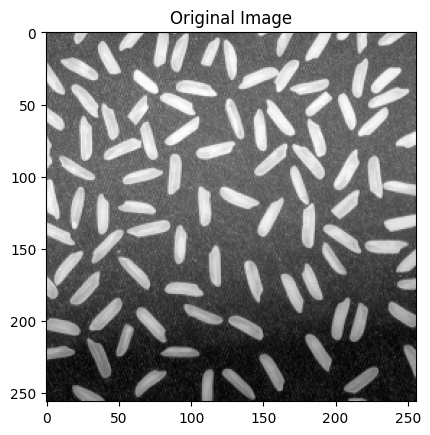

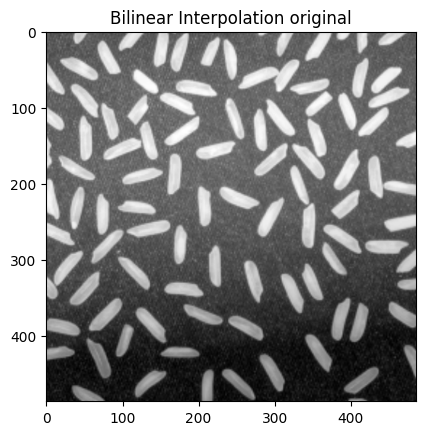

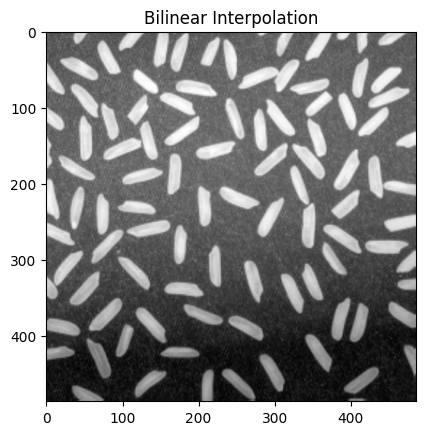

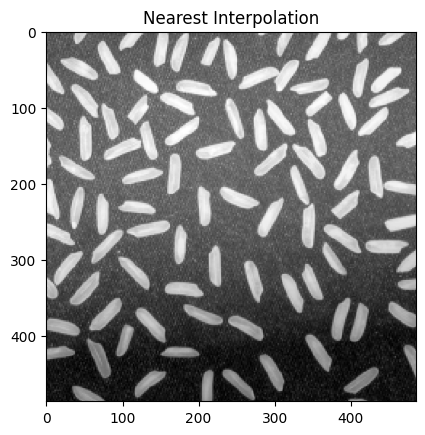

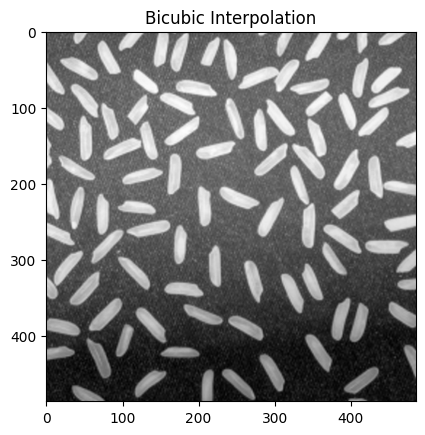

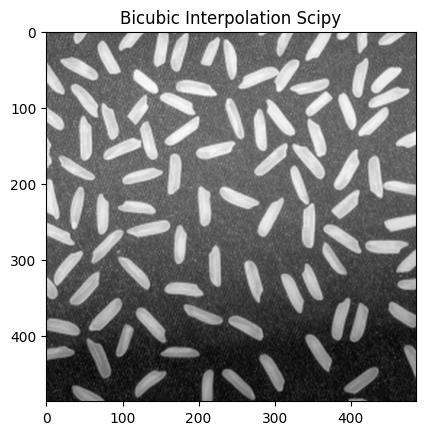

In [8]:
if __name__ == "__main__":
    print("This is a module for image interpolation.")
    dim = round(256*1.9)
    print(f"The new dimension is {dim}*{dim}.")
    image = plt.imread("rice.tif")
    # timing
    start = time.time()
    img_nearest = nearest_huangtingjun("rice.tif", (dim,dim))
    end = time.time()
    print(f"Nearest: {end-start} seconds.")

    start = time.time()
    img_bilinear_original = bilinear_original("rice.tif", (dim,dim))
    end = time.time()
    print(f"Bilinear type1: {end-start} seconds.")

    start = time.time()
    img_bilinear = bilinear_huangtingjun("rice.tif", (dim,dim))
    end = time.time()
    print(f"Bilinear type2: {end-start} seconds.")

    start = time.time()
    img_bicubic_huangtingjun = bicubic_huangtingjun("rice.tif", (dim,dim))
    end = time.time()
    print(f"Bicubic: {end-start} seconds.")

    start = time.time()
    img_bicubic_scipy = bicubic_scipy("rice.tif", (dim,dim))
    end = time.time()
    print(f"Bicubic Scipy: {end-start} seconds.")

    
    img_original = Image.fromarray(image)
    img_bilinear_original_pil = Image.fromarray(img_bilinear_original)
    img_bilinear_pil = Image.fromarray(img_bilinear)
    img_nearest_pil = Image.fromarray(img_nearest)
    img_bicubic_pil = Image.fromarray(img_bicubic_huangtingjun)
    img_bicubic_scipy = Image.fromarray(img_bicubic_scipy)
    img_original.save("rice_original.jpg")
    img_bilinear_original_pil.save("enlarged_bilinear1_huangtingjun.jpg")
    img_bilinear_pil.save("enlarged_bilinear2_huangtingjun.jpg")
    img_nearest_pil.save("enlarged_nearest_huangtingjun.jpg")
    img_bicubic_pil.save("enlarged_bicubic_huangtingjun.jpg")
    img_bicubic_scipy.save("enlarged_bicubic_scipy.jpg")

    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.show()

    plt.imshow(img_bilinear_original, cmap="gray")
    plt.title("Bilinear Interpolation original")
    plt.show()
    
    plt.imshow(img_bilinear, cmap="gray")
    plt.title("Bilinear Interpolation")
    plt.show()

    plt.imshow(img_nearest, cmap="gray")
    plt.title("Nearest Interpolation")
    plt.show()

    plt.imshow(img_bicubic_huangtingjun, cmap="gray")
    plt.title("Bicubic Interpolation")
    plt.show()

    plt.imshow(img_bicubic_scipy, cmap="gray")
    plt.title("Bicubic Interpolation Scipy")
    plt.show()


    
    
